Analyze how covariate matching changes when we use propensity matching in the GAN latent space.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matching
from config import *
from style import cb, cr
import data
import util
import viz

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')

# add Race = Black
k_group = 'gender'
df['Race=Black'] = 0
df.loc[df['race4_pred'] == 'Black', 'Race=Black'] = 1

# fit propensity scores
**matching code based on [here](https://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb)**

In [2]:
# read in all the latents
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
latents = np.array([np.load(oj(DIR_GEN, f))
                    for f in fname_nps]).mean(axis=1) # restricted style space

Accuracy 0.98


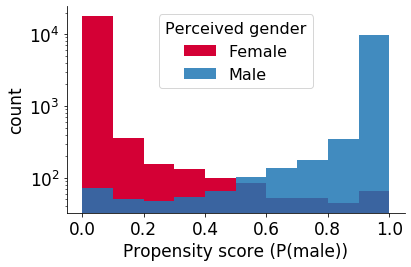

In [3]:
# fit and caclulate the propensity scores
lm = LogisticRegression(random_state=42)
lm = lm.fit(latents, df['gender']) #data[names[1:-1]], data.Treated)
print('Accuracy', lm.score(latents, df['gender']).round(3))
pscores = lm.predict_proba(latents)[:, 1] # The predicted propensities by the model
plt.hist(pscores[df['gender'] == 0], label='Female', color=cr)
plt.hist(pscores[df['gender'] == 1], label='Male', alpha=0.85, color=cb)
df['pscores'] = pscores
plt.xlabel('Propensity score (P(male))')
plt.ylabel('count')
plt.yscale('log')
plt.legend(title='Perceived gender')
util.savefig('scores_propensity')
plt.show()

In [4]:
d = df.reset_index()
matches1, matches2 = matching.calc_propensity_matches(d['gender'], d['pscores'], caliper=0.05)

df_matched = d.loc[matches1 + matches2]
print('num matches', df_matched['gender'].shape[0])

100%|██████████| 10914/10914 [00:09<00:00, 1127.76it/s]

num matches 1186


# mean diff checking

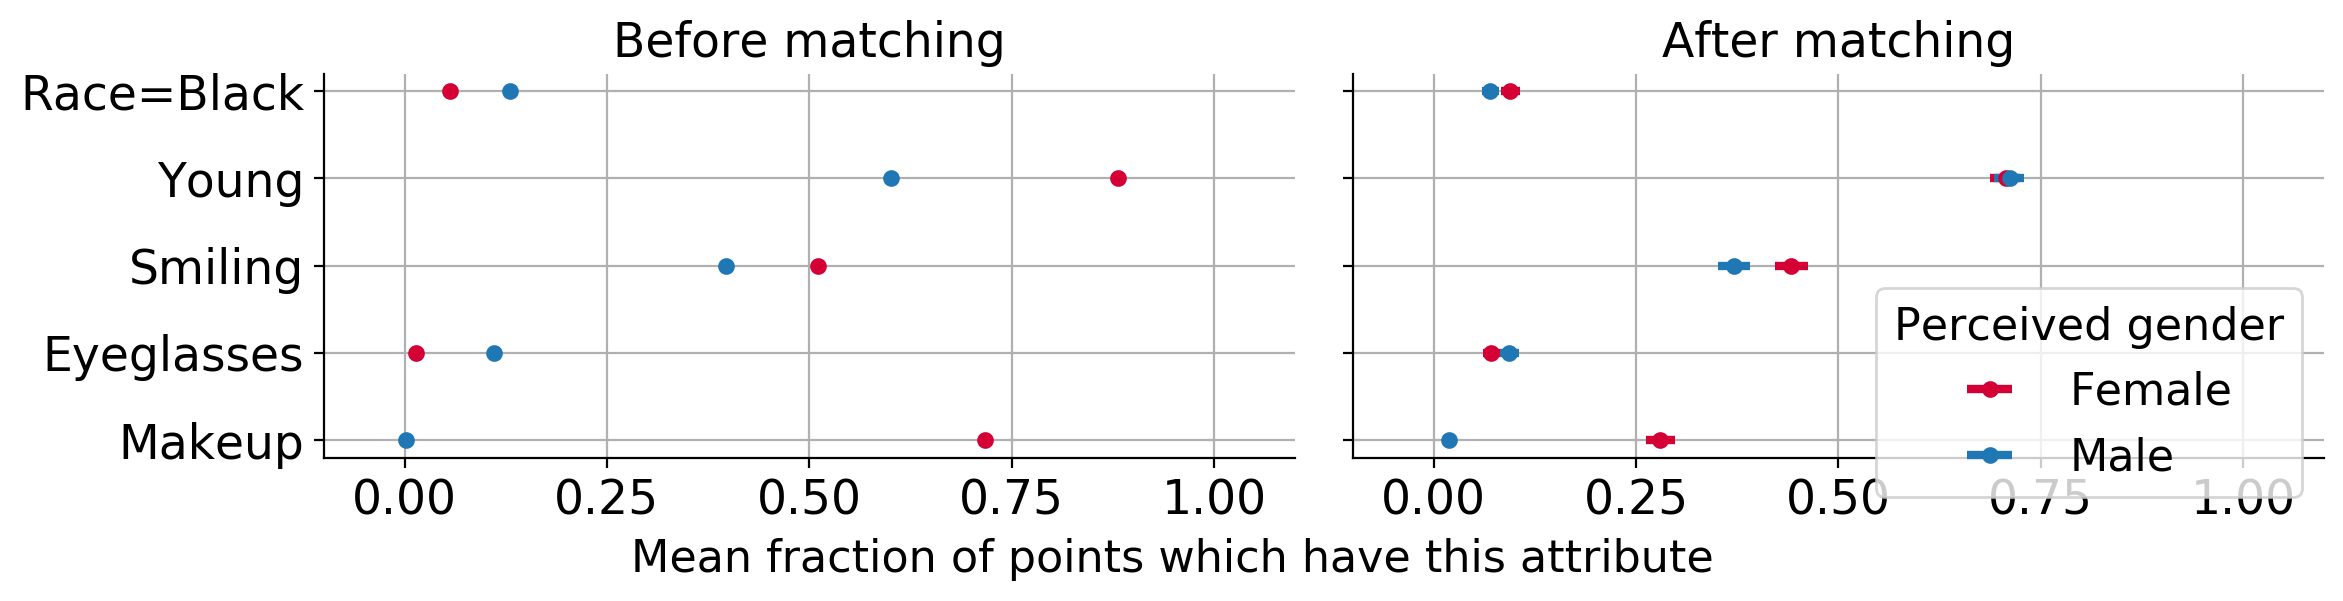

In [5]:
ds = [df, df_matched]
ks = [ #'yaw', 'pitch', 'roll',
         'Race=Black', 'young', 'smiling',
          'eyeglasses', 'makeup', 'gender',
          ][::-1] #, 'background_mean']
viz.plot_subgroup_mean_diffs(ds, ks, k_group, titles=['Before matching', 'After matching'])
util.savefig('means_matching_propensity')
plt.show()

/home/ubuntu/face-disentanglement/matching_benchmarking/matching.py:328: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matched['Race=Black'] = 0
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


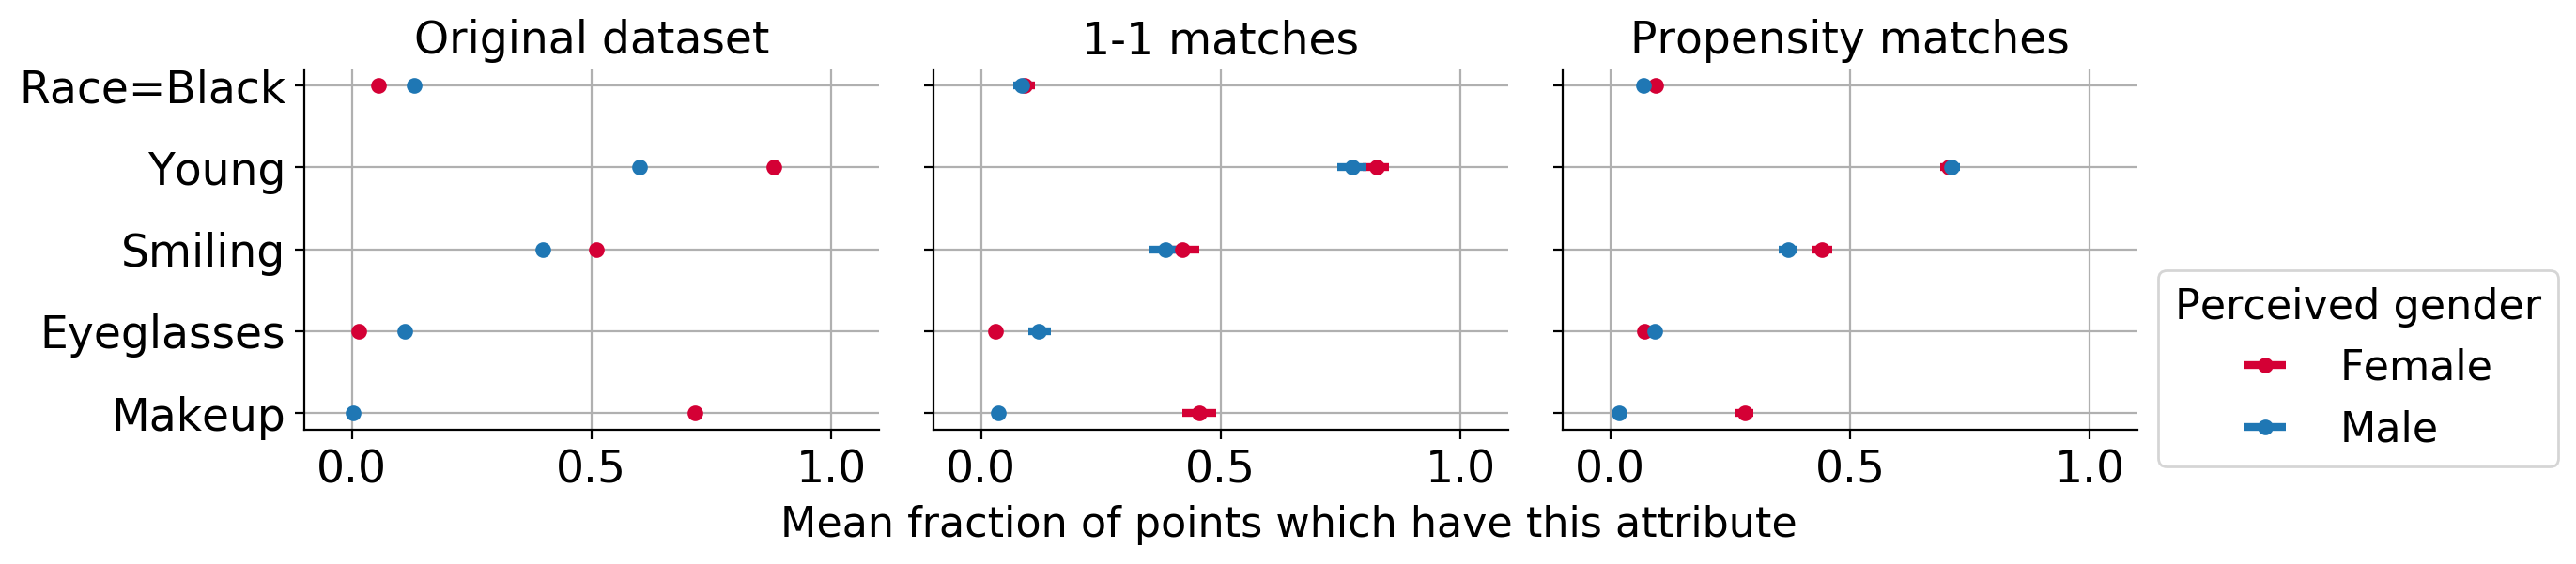

In [10]:
# plot propensity results next to the 1-1 matching results
df_matched_one_to_one, _ = matching.matches_to_df(pd.read_pickle(oj(DIR_PROCESSED, 'matches_gender_200.pkl')),
                                                  df, 'gender')
ds = [df, df_matched_one_to_one, df_matched]
ks = [ #'yaw', 'pitch', 'roll',
         'Race=Black', 'young', 'smiling',
          'eyeglasses', 'makeup', 'gender',
          ][::-1] #, 'background_mean']
viz.plot_subgroup_mean_diffs(ds, ks, k_group,
                             figsize=(14, 3),
                             titles=['Original dataset', '1-1 matches', 'Propensity matches'])
util.savefig('means_matching_full')
plt.show()

# intersectional mean diffs
**means across different intersectional subgroups**

<Figure size 2800x2200 with 0 Axes>

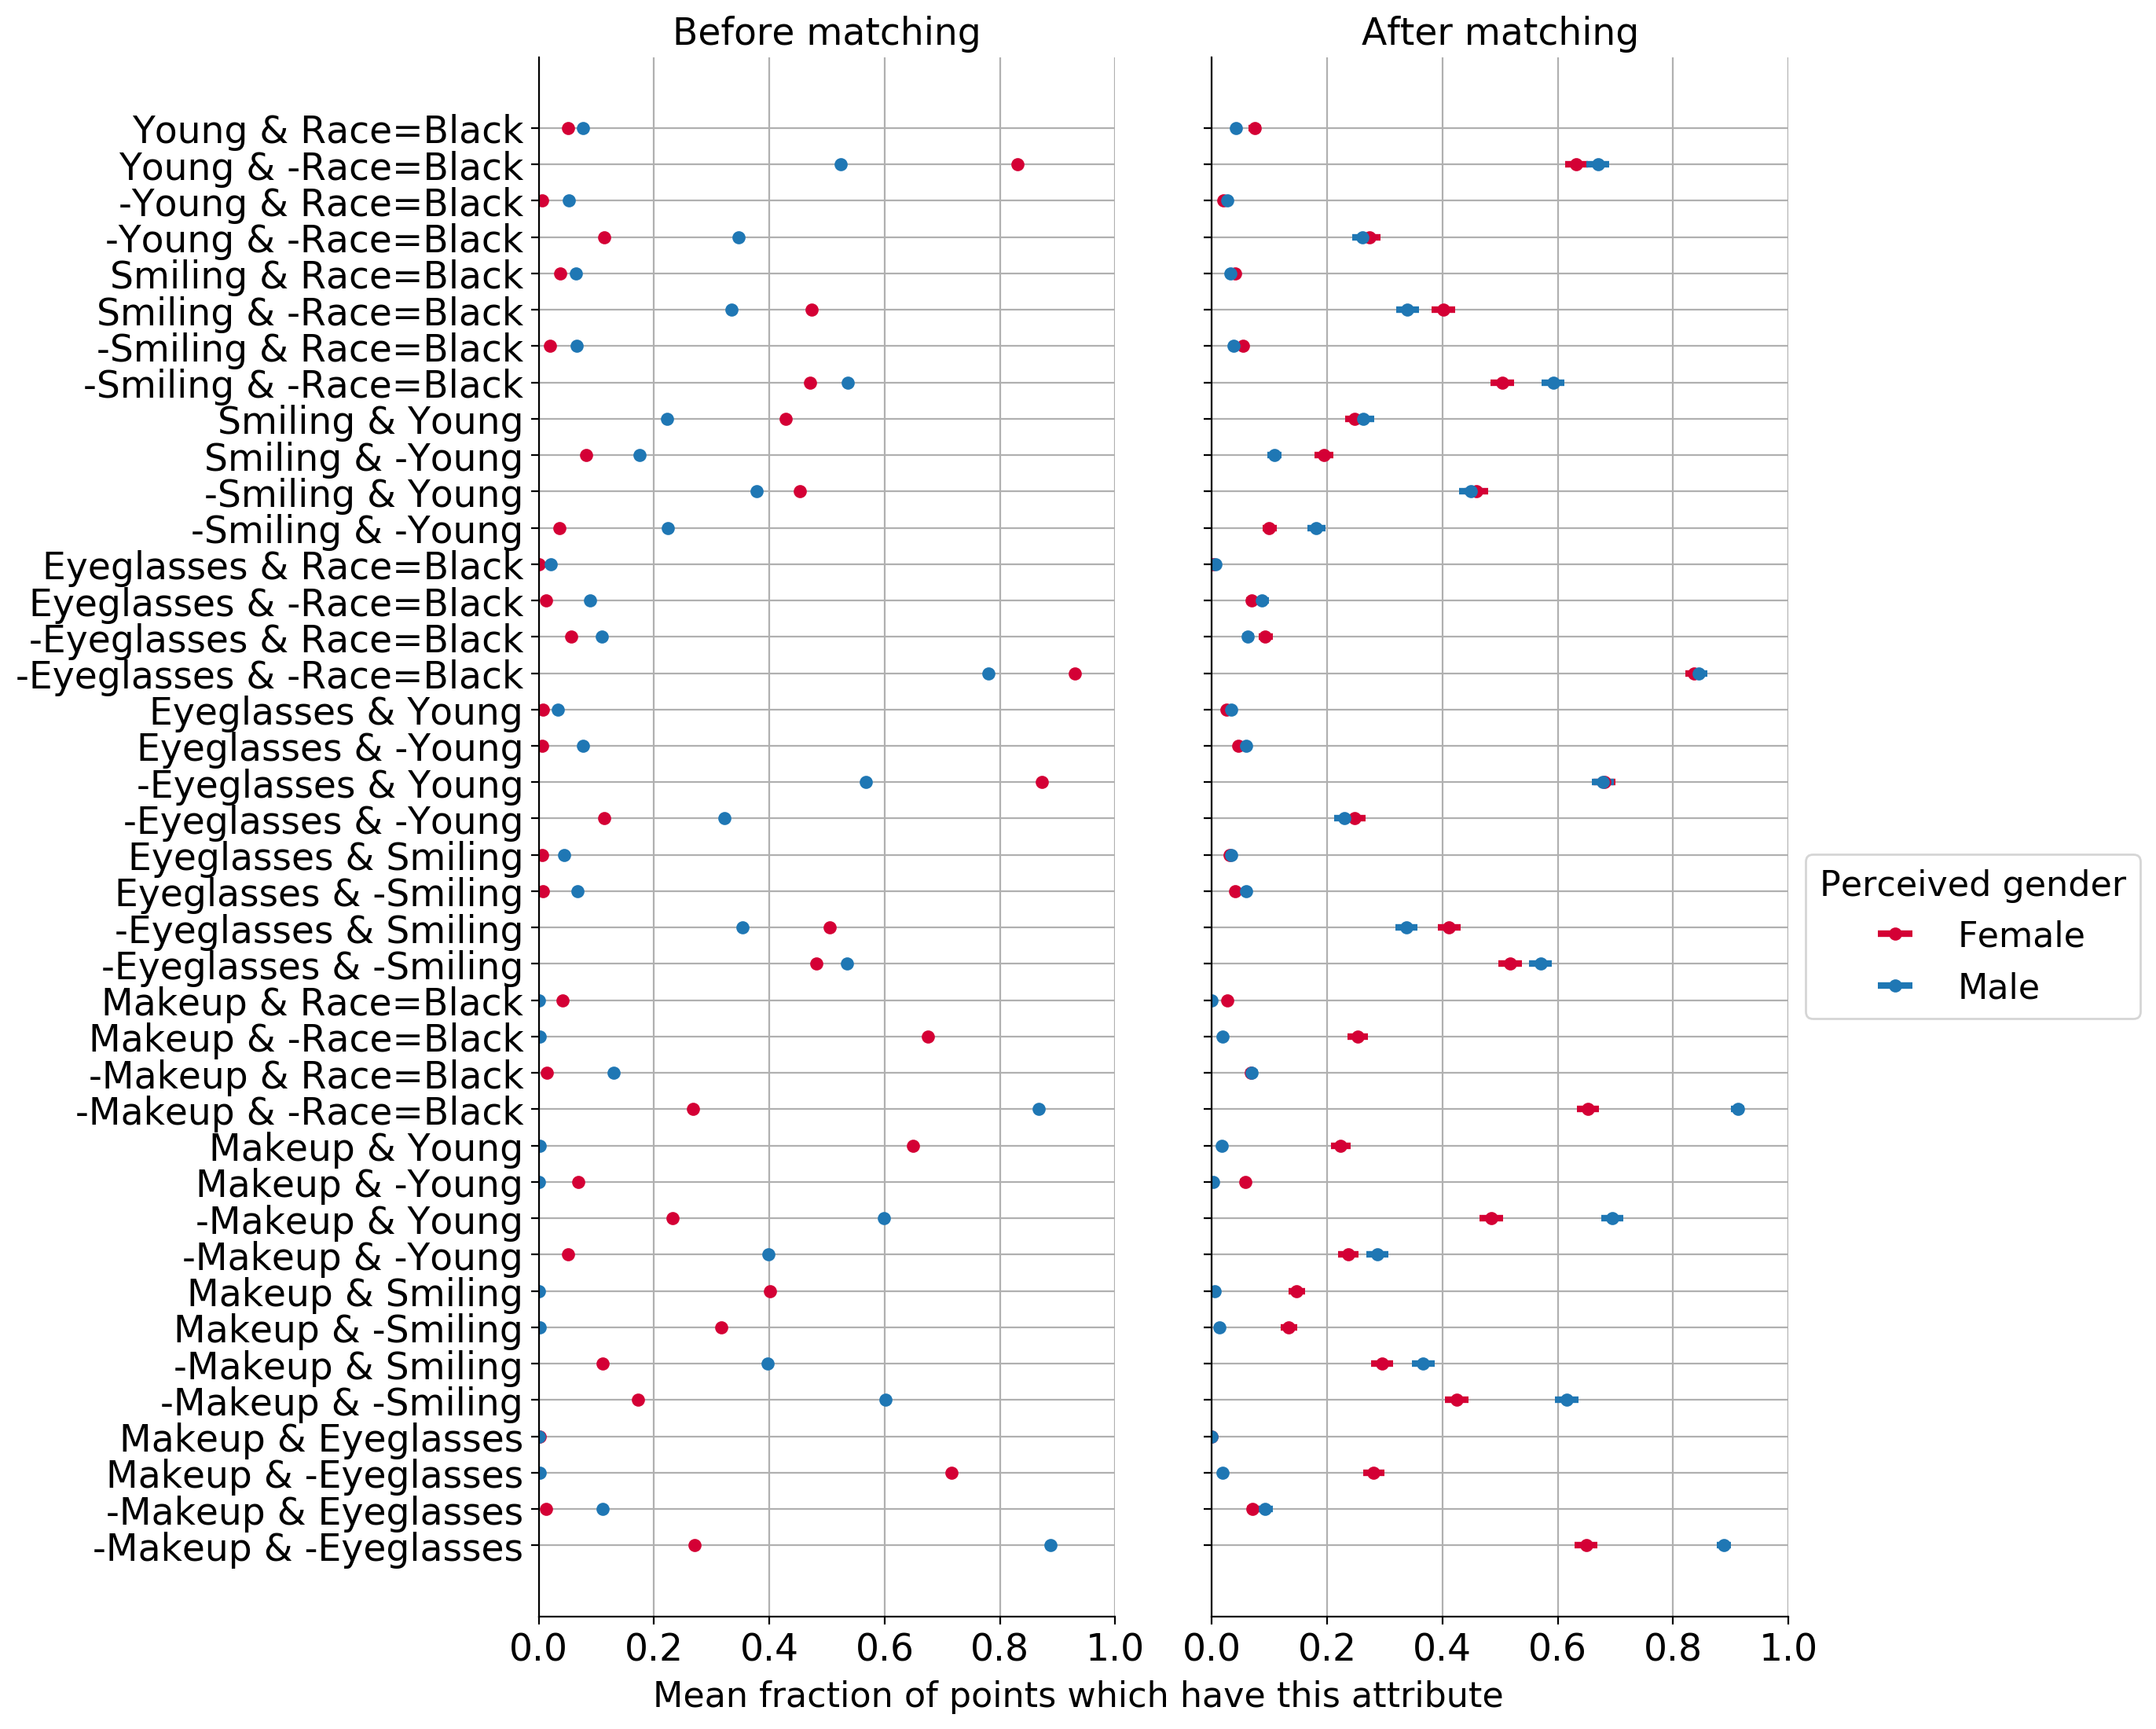

In [42]:
R, C = 1, 2
fig = plt.figure(dpi=200, figsize=(14, 11))
ks_init = ['Race=Black', 'young', 'smiling', 'eyeglasses', 'makeup', 'gender']
df_int, ks = matching.add_intersections(df, ks_init)
df_matched_int, ks = matching.add_intersections(df_matched, ks_init)
ds = [df_int, df_matched_int]
ks = ks[::-1] + ['gender']
viz.plot_subgroup_mean_diffs(ds, ks, k_group, figsize=(14, 11))


util.savefig('means_intersectional_matching_propensity')
plt.show()